# Regressão Linear 

Neste notebook, será utilizada a regressão linear a fim de predizer o valor a ser pago em uma corrida de táxi

In [252]:
# Importando algumas bibliotecas básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action='ignore')

# Importando o folium para visualizar o mapa geográfico de NY

import folium as flm
from folium.plugins import HeatMap

In [253]:
# Importando o dataset

df = pd.read_csv("dataset.csv")

In [254]:
# Visualizando o número de linhas e colunas

df.shape

(1000000, 8)

#### Descrição do conjunto de dados

|Campo            | Descrição                                                  |
|-----------------|------------------------------------------------------------|
|key              |chave única indicando cada exemplo                          |
|**fare_amount**  |valor, em doláres, indicando o valor pago na corrida de táxi|
|pickup_datetime  |timestamp indicando quando a corrida começou                |
|pickup_longitude |longitude na qual a corrida de táxi começou                 |
|pickup_latitude  |latitude na qual a corrida de táxi começou                  |
|dropoff_longitude|longitude na qual a corrida de táxi acabou                  |
|dropoff_latitude |latitude na qual a corrida de táxi acabou                   |
|passenger_count  |número de passageiros                                       |

In [255]:
# Observando os dados

df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
999995,2014-09-13 21:44:38.0000001,7.0,2014-09-13 21:44:38 UTC,-73.976676,40.785630,-73.959196,40.775114,1
999996,2010-09-20 14:50:37.0000002,7.3,2010-09-20 14:50:37 UTC,-73.992103,40.671385,-73.992103,40.671385,2
999997,2013-04-26 14:03:00.000000118,10.5,2013-04-26 14:03:00 UTC,-73.978423,40.751135,-73.993397,40.762197,5
999998,2011-07-08 00:29:00.00000099,6.9,2011-07-08 00:29:00 UTC,-73.980317,40.759482,-73.976832,40.743122,1


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


## EDA e Feature Engineering

### Valores faltantes

In [257]:
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

Como são poucos os casos de valores faltantes, eles serão simplesmente excluídos

In [258]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df.dropna(inplace=True)
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 1000000
Tamanho conjunto de dados (depois da remoção de valores faltantes): 999990


### Distribuição das features

A fim de observar a distribuição dos dados, será utilizado o df.describe e para ver se os valores mínimos e máximos estão distantes de 1% e 99% dos dados, respectivamente, serão observados os percentis 1 e 99

In [259]:
df.describe(include='all', percentiles = [.01, .05, .25, .5, .75, .95, .99]).T

,count,unique,top,freq,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
key,999990,999990,2009-06-15 17:26:21.0000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare_amount,999990.0,NaN,NaN,NaN,11.347953,9.82179,-44.9,3.3,4.1,6.0,8.5,12.5,30.33,52.33,500.0
pickup_datetime,999990,861747,2010-02-13 19:28:00 UTC,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,999990.0,NaN,NaN,NaN,-72.526699,12.057778,-3377.680935,-74.014315,-74.006795,-73.99206,-73.981792,-73.967094,-73.871382,0.0,2522.271325
pickup_latitude,999990.0,NaN,NaN,NaN,39.92904,7.626087,-3116.285383,0.0,40.702337,40.734965,40.752695,40.767154,40.787746,40.806948,2621.62843
dropoff_longitude,999990.0,NaN,NaN,NaN,-72.52786,11.324494,-3383.296608,-74.015238,-74.00737,-73.991385,-73.980135,-73.963654,-73.877719,0.0,45.581619
dropoff_latitude,999990.0,NaN,NaN,NaN,39.919954,8.201418,-3114.338567,0.0,40.686603,40.734046,40.753166,40.768129,40.79388,40.830913,1651.553433
passenger_count,999990.0,NaN,NaN,NaN,1.684941,1.323907,0.0,1.0,1.0,1.0,1.0,2.0,5.0,6.0,208.0


Observações realizadas que distoam da realidade:

- **fare_amount:** há valores pagos negativos e valores exageradamente altos ($ 500) enquanto que 99% das corridas tiveram valores de $52.33 para baixo
- **pickup_longitude e dropoff_longitude:** a longitude varia de -180 a 180 e há valores muito menores e maiores
- **pickup_latitude e dropoff_latitude:** a latitude varia de -180 a 180 e há valores muito menores e maiores
- **passenger_count:** há corridas com 208 e corridas sem nenhum passageiro

### Análise das features (e do target)

**`fare_amount`**

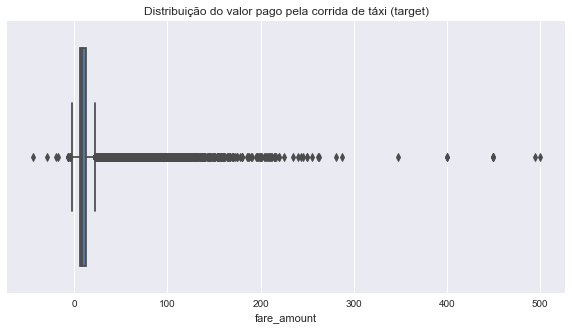

In [260]:
# Observando a distribuição do target

figure(figsize=(10, 5))
sns.boxplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target)");

De acordo com <a href = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/63319'>este link</a>, a taxa mínima é $2.50, portando, valores abaixo de $2.50 serão excluídos

In [261]:
len(df.loc[(df.fare_amount < 2.5)])

77

In [262]:
# Observando valores acima de 100 dólares

len(df.loc[(df.fare_amount > 100)])

396

In [263]:
# Removendo dados distoantes

df = df.loc[(df.fare_amount >= 1) & (df.fare_amount <= 100)]

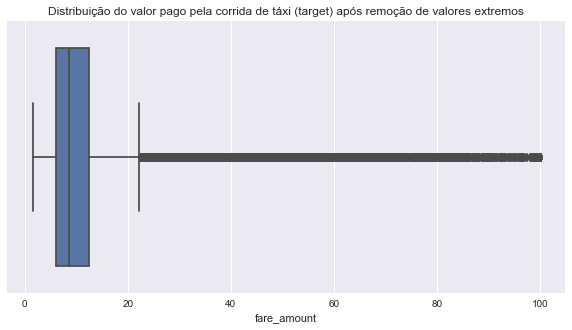

In [264]:
# Observando novamente a distribuição

figure(figsize=(10, 5))
sns.boxplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target) após remoção de valores extremos");

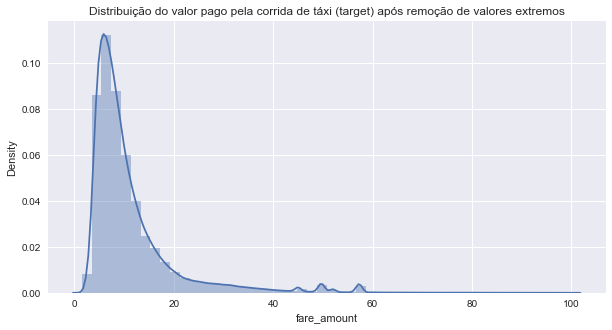

In [265]:
figure(figsize=(10, 5))
sns.distplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target) após remoção de valores extremos");

É possível observar que corridas acima de $20 são mais raras e há alguns picos entre $40 e $60

**`pickup_datetime`**

In [266]:
# Convertendo esta feature em data através do pandas para se seja possível manipulá-la

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999519 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                999519 non-null  object        
 1   fare_amount        999519 non-null  float64       
 2   pickup_datetime    999519 non-null  datetime64[ns]
 3   pickup_longitude   999519 non-null  float64       
 4   pickup_latitude    999519 non-null  float64       
 5   dropoff_longitude  999519 non-null  float64       
 6   dropoff_latitude   999519 non-null  float64       
 7   passenger_count    999519 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 68.6+ MB


In [267]:
# Separando ainda mais

# Horário
df['pickup_hour']=df['pickup_datetime'].apply(lambda x:x.hour)

# Dia da semana (0 é segunda e 6 é domingo)
df['pickup_day_of_week']=df['pickup_datetime'].apply(lambda x:x.weekday())

# Dia
df['pickup_day']=df['pickup_datetime'].apply(lambda x:x.day)

# Mês
df['pickup_month']=df['pickup_datetime'].apply(lambda x:x.month)

# Ano
df['pickup_year']=df['pickup_datetime'].apply(lambda x:x.year)

In [268]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day_of_week,pickup_day,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,0,15,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,1,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,18,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,5,21,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,9,3,2010


**Horário**

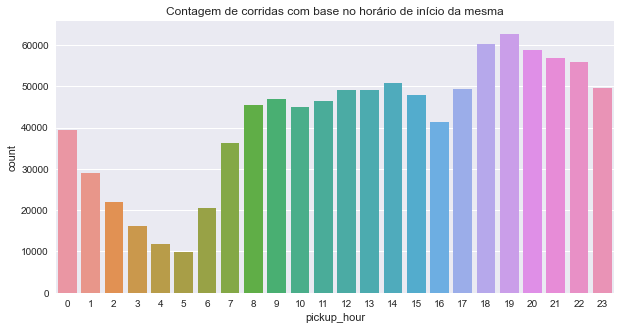

In [269]:
figure(figsize=(10, 5))
sns.countplot(df['pickup_hour']).set_title("Contagem de corridas com base no horário de início da mesma");

<Figure size 720x360 with 0 Axes>

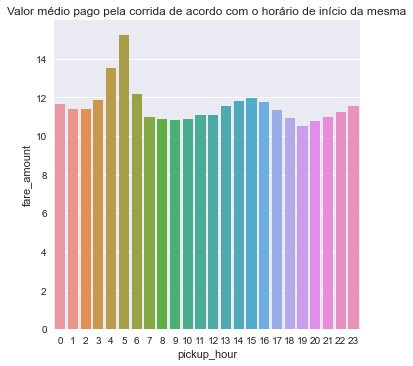

In [270]:
figure(figsize=(10, 5))
sns.catplot(x="pickup_hour", y="fare_amount", data=df,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com o horário de início da mesma");

É possível notar que as corridas que começam na madrugada são menos frequentes. Por outro lado, a média dos seus valores parece maior do que dos demais horários.

**Dia da semana**

In [271]:
# Convertendo os dias da semana para facilitar a leitura

def convert_day_of_week(day_of_week):
    day_dict={0:'Segunda',1:'Terça',2:'Quarta',3:'Quinta',4:'Sexta',5:'Sábado',6:'Domingo'}
    return day_dict[day_of_week]

In [272]:
df['pickup_day_of_week_name']=df['pickup_day_of_week'].apply(lambda x:convert_day_of_week(x))

In [273]:
week_day_name = ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado','Domingo']

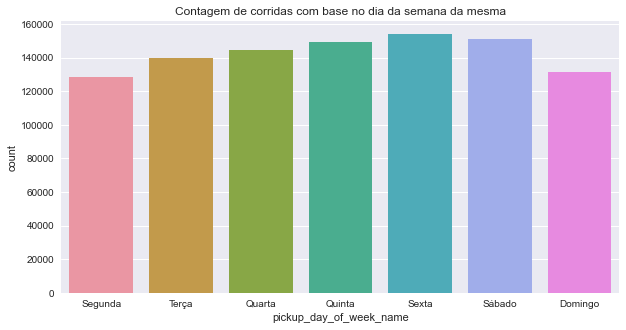

In [274]:
figure(figsize=(10, 5))
sns.countplot(df['pickup_day_of_week_name'],order=week_day_name).set_title("Contagem de corridas com base no dia da semana da mesma");

<Figure size 720x360 with 0 Axes>

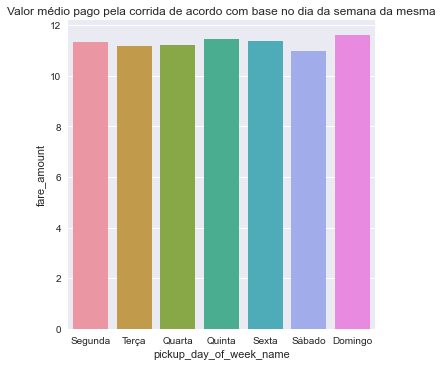

In [275]:
figure(figsize=(10, 5))
sns.catplot(x="pickup_day_of_week_name", y="fare_amount", data=df,
            order=week_day_name,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com base no dia da semana da mesma");

É possível notar que o pico no número de corridas ocorre nas sextas-feiras. Por outro lado, a média do valor pago pelas corridas parece um pouco maior no domingo do que nos demais dias da semana.

**Dia**

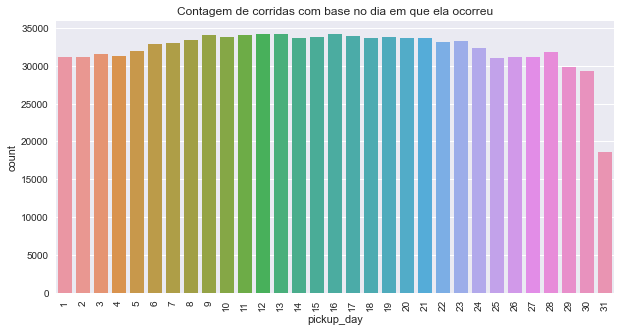

In [276]:
figure(figsize=(10, 5))
sns.countplot(df['pickup_day']).set_title("Contagem de corridas com base no dia em que ela ocorreu");
plt.xticks(rotation=90);

<Figure size 720x360 with 0 Axes>

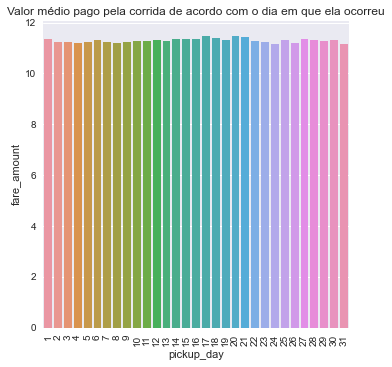

In [277]:
figure(figsize=(10, 5))
sns.catplot(x="pickup_day", y="fare_amount", data=df,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com o dia em que ela ocorreu");
plt.xticks(rotation=90);

Como nem todos os meses tem 31 dias, faz sentido haver menos corrida em que exista esse dia no mês. Já observando a média dos valores pagos por dia da semana, não é possível notar uma clara diferença.

**Mês**

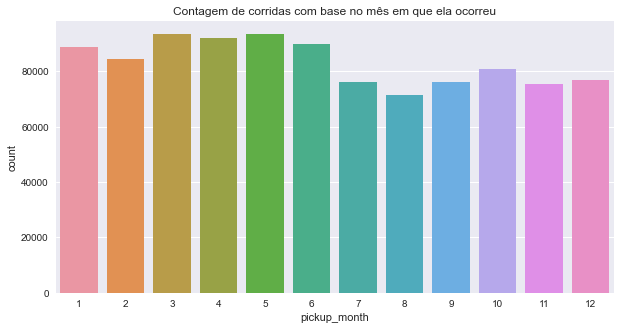

In [278]:
figure(figsize=(10, 5))
sns.countplot(df['pickup_month']).set_title("Contagem de corridas com base no mês em que ela ocorreu");

<Figure size 720x360 with 0 Axes>

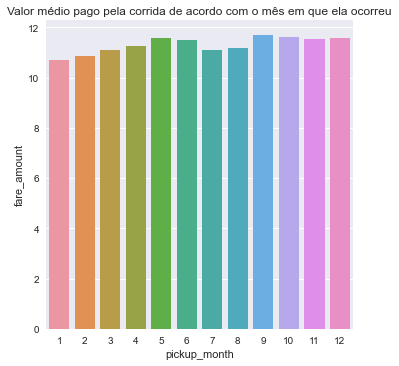

In [279]:
figure(figsize=(10, 5))
sns.catplot(x="pickup_month", y="fare_amount", data=df,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com o mês em que ela ocorreu");

Com relação ao mês, aparentemente mais corridas de táxi são feitas no primeiro semestre do que no segundo. Já em relação à média do valor pago, os meses do começo do ano e do meio do ano parecem ter valores menores do que os demais meses. 

**Ano**

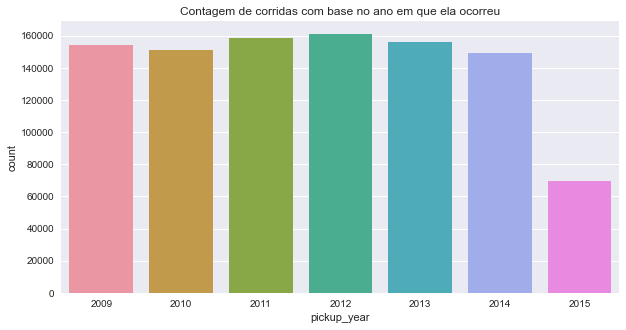

In [280]:
figure(figsize=(10, 5))
sns.countplot(df['pickup_year']).set_title("Contagem de corridas com base no ano em que ela ocorreu");

<Figure size 720x360 with 0 Axes>

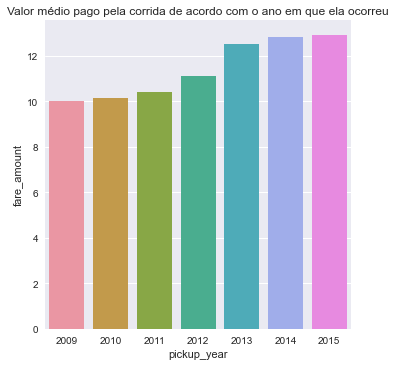

In [281]:
figure(figsize=(10, 5))
sns.catplot(x="pickup_year", y="fare_amount", data=df,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com o ano em que ela ocorreu");

Para a feature que indica o ano da corrida, nota-se que o ano de 2015 contém bem menos corridas do que os demais anos. Uma hipótese para que isso tenha acontecido é que o conjunto de dados foi coletado no meio desse ano e, portanto, ainda não haviam dados do ano inteiro.

Com relação ao valor pago, é notável que há uma tendência de crescimento na média do valor pago pela corrida conforme os anos vão passando.

**`latitude e longitude`**

In [282]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,999519.000000,999519.000000,999519.000000,999519.000000
mean,39.930365,-72.529162,39.921741,-72.531198
std,7.623472,12.051418,8.198080,11.314573
min,-3116.285383,-3377.680935,-3114.338567,-3383.296608
1%,0.000000,-74.014295,0.000000,-74.015177
5%,40.702395,-74.006793,40.686676,-74.007357
25%,40.734977,-73.992061,40.734055,-73.991382
50%,40.752697,-73.981796,40.753166,-73.980136
75%,40.767151,-73.967110,40.768122,-73.963666
95%,40.787736,-73.872194,40.793817,-73.878775


Como observado antes, a latitude e longitude possuem valores muito discrepantes do real. Será excluido todos os exemplos cujas longitudes e latitudes estão fora do intervalo da realidade:

In [283]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df = df.loc[(df.pickup_latitude>=-90) & (df.pickup_latitude<=90)]
df = df.loc[(df.pickup_longitude>=-180) & (df.pickup_longitude<=180)]
df = df.loc[(df.dropoff_latitude>=-90) & (df.dropoff_latitude<=90)]
df = df.loc[(df.dropoff_longitude>=-180) & (df.dropoff_longitude<=180)]
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 999519
Tamanho conjunto de dados (depois da remoção de valores faltantes): 999479


In [284]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,999479.000000,999479.000000,999479.000000,999479.000000
mean,39.928068,-72.519762,39.927656,-72.518556
std,6.085292,10.385367,6.088085,10.386105
min,-74.016587,-128.175950,-74.035197,-121.391248
1%,0.000000,-74.014288,0.000000,-74.015175
5%,40.702396,-74.006792,40.686680,-74.007356
25%,40.734977,-73.992060,40.734055,-73.991382
50%,40.752697,-73.981796,40.753165,-73.980136
75%,40.767151,-73.967110,40.768122,-73.963666
95%,40.787733,-73.872210,40.793816,-73.878792


**Pontos de origem da corrida**

In [285]:
# Determinando os intervalores de longitude e latitude

long_interval = (-74.05, -73.7)
lat_interval = (40.6, 40.85)

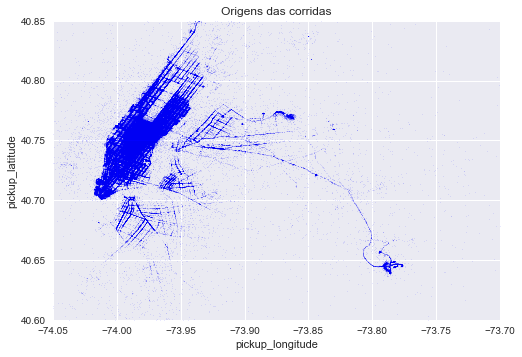

In [286]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Origens das corridas")
plt.ylim(lat_interval)
plt.xlim(long_interval);

In [287]:
# Criando uma função para plotar o mapa de calor das corridas

def mapa_corridas(lat, lon):
    map_nyc = flm.Map(location = [40.7141667, -74.0063889], zoom_start = 12, tiles = "Stamen Toner")
    flm.Marker(location = [40.7141667, -74.0063889], icon = flm.Icon(color = 'red'), popup='NYC').add_to(map_nyc)
    lat_lon = df.loc[0:20000, [lat, lon]].values
    HeatMap(lat_lon, radius = 10).add_to(map_nyc)
    return map_nyc

In [288]:
mapa_corridas('pickup_latitude', 'pickup_longitude')

filtando as longitudes e latitudes para considerar somente intervalos em que é possível observar o mapa de NY:

In [289]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df = df.loc[(df.pickup_latitude>=40.6) & (df.pickup_latitude<=40.85)]
df = df.loc[(df.pickup_longitude>=-74.05) & (df.pickup_longitude<=-73.7)]
df = df.loc[(df.dropoff_latitude>=40.6) & (df.dropoff_latitude<=40.85)]
df = df.loc[(df.dropoff_longitude>=-74.05) & (df.dropoff_longitude<=-73.7)]
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 999479
Tamanho conjunto de dados (depois da remoção de valores faltantes): 969777


**Pontos de destino da corrida**

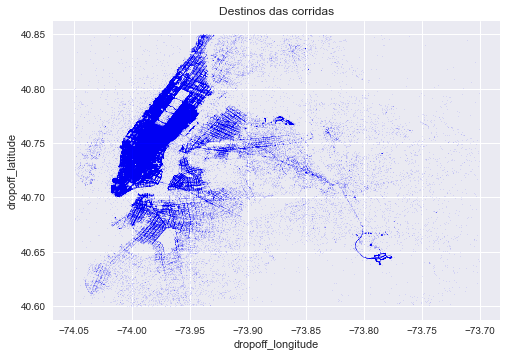

In [290]:
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Destinos das corridas");

In [291]:
mapa_corridas('dropoff_latitude', 'dropoff_longitude')

Comparando com o mapa das origens, é possível ver que há mais destinos fora de Manhattan, o que indica que muitas corridas começam em Manhattan e terminam no Brooklyn e no Queens.

In [292]:
# Criando novas variáveis para as diferenças absolutas entre as latitudes e as longitudes de origem e destino das corridas:

df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [293]:
df[['abs_diff_latitude', 'abs_diff_longitude']].describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])

,abs_diff_latitude,abs_diff_longitude
count,969777.000000,969777.000000
mean,0.020645,0.022104
std,0.021492,0.032527
min,0.000000,0.000000
1%,0.000000,0.000000
5%,0.001196,0.000968
25%,0.006907,0.006104
50%,0.014052,0.012604
75%,0.026764,0.023578
95%,0.061499,0.089486


**`passenger_count`**

Conforme visto, há casos de corridas com 208 passageiros e também há corridas sem passageiros.

Como a maioria dos táxis só cabe 5 pessoas, sendo umas delas o motorista, restam 4 vagas para passageiros. Portando, serão excluídos os casos de corridas sem passageiros ou com mais de 4:

In [294]:
len(df.loc[df.passenger_count<1])

3458

In [295]:
len(df.loc[df.passenger_count>4])

88964

In [296]:
df = df.loc[(df.passenger_count > 0) & (df.passenger_count<5)]

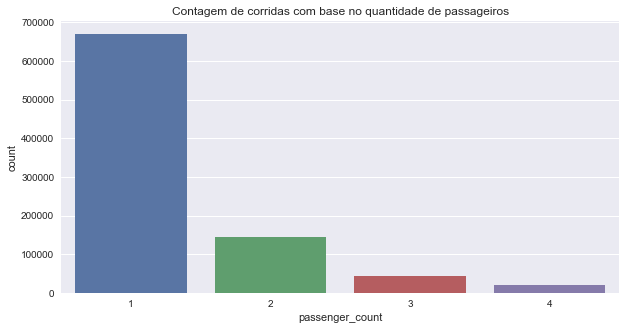

In [297]:
figure(figsize=(10, 5))
sns.countplot(df['passenger_count']).set_title("Contagem de corridas com base no quantidade de passageiros");

<Figure size 720x360 with 0 Axes>

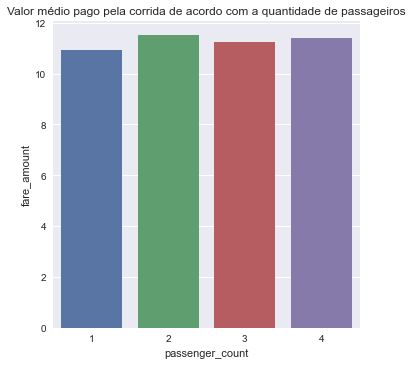

In [298]:
figure(figsize=(10, 5))
sns.catplot(x="passenger_count", y="fare_amount", data=df,kind="bar", ci = None).set(title="Valor médio pago pela corrida de acordo com a quantidade de passageiros");

São poucas as corridas com 4 passageiros, sendo a maioria com apenas 1

Com relação ao valor pago, essas corridas com somente um passageiro parecem ter uma média ligeiramente menor do que as corridas com mais passageiros.

In [299]:
# Criando uma feature para a distância da corrida em km

def distancia(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    b = 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
    return b * 1.60934

In [300]:
df['trip_distance'] = df.apply(lambda linha:distancia(linha['pickup_latitude'], linha['dropoff_latitude'], linha['pickup_longitude'], linha['dropoff_longitude']), axis=1)

Text(0.5, 1.0, 'Distribuição da distância da corrida (escala em log)')

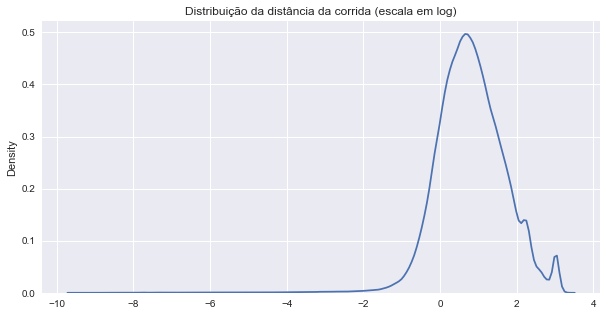

In [301]:
figure(figsize=(10, 5))
sns.kdeplot(np.log(df['trip_distance'].values)).set_title("Distribuição da distância da corrida (escala em log)")

### Correlação

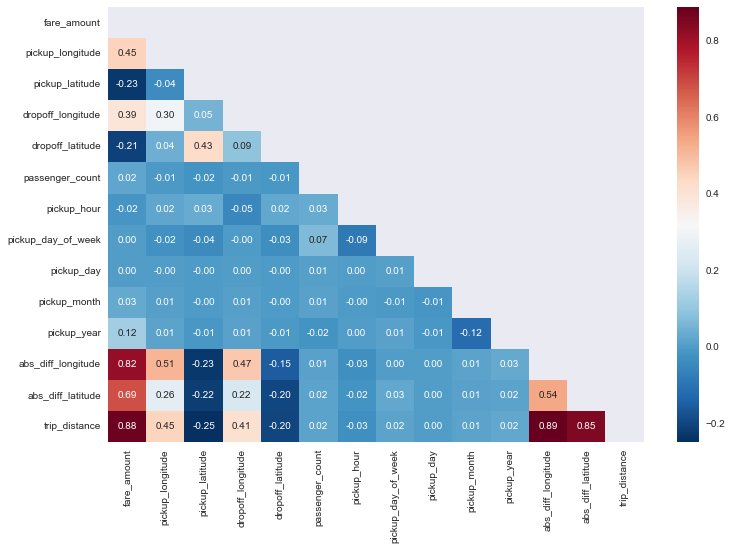

In [302]:
# Plotando a matriz de correlações usando heatmap

sns.set_context(font_scale=2.0)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdBu_r', mask=np.triu(np.ones_like(df.corr())))
plt.show()

De acordo com a matriz de correlação acima, as features criadas referentes às coordenadas de latitude e longitude são as mais correlacionadas ao target

### Regressão Linear Simples

In [303]:
from sklearn.linear_model import LinearRegression

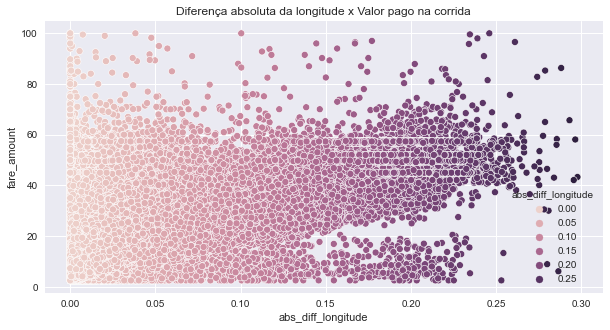

In [304]:
# Variável target x variável com a diferença absoluta entre as longitudes de origem e destino

figure(figsize=(10, 5))
sns.scatterplot(x='abs_diff_longitude', y='fare_amount', data=df, hue='abs_diff_longitude')
plt.title('Diferença absoluta da longitude x Valor pago na corrida');

In [305]:
# Observando a correlação entre as features

df.fare_amount.corr(df.abs_diff_longitude)

0.8212928413533832

Text(0.5, 1.0, 'Distância da corrida x Fare Amount')

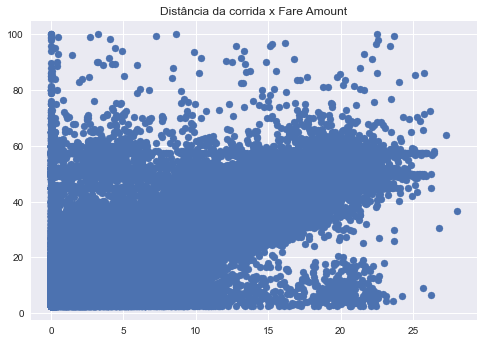

In [306]:
# Variável target x distância da corrida

plt.scatter(x=df['trip_distance'], y=df['fare_amount'])
plt.title("Distância da corrida x Fare Amount")

In [307]:
# Observando a correlação entre as features

df.fare_amount.corr(df.trip_distance)

0.8774688843302134

#### Separação do conjunto de treino e teste

In [308]:
X = df.drop(['fare_amount'], axis = 1)
Y = df['fare_amount']

In [309]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [310]:
# Observando o formato dos dados de treino e de teste

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((614148, 16), (263207, 16), (614148,), (263207,))

#### Treinamento do modelo

Treinando os modelos com as features mais correlacionadas com o target

In [311]:
modelo1 = LinearRegression()
modelo1.fit(X_train[['trip_distance']], Y_train)

LinearRegression()

In [312]:
modelo2 = LinearRegression()
modelo2.fit(X_train[['abs_diff_longitude']], Y_train)

LinearRegression()

In [313]:
modelo3 = LinearRegression()
modelo3.fit(X_train[['abs_diff_latitude']], Y_train)

LinearRegression()

#### Predição

In [314]:
# Modelo 1 - 'trip_distance'

Y_pred = modelo1.predict(X_test[['trip_distance']])

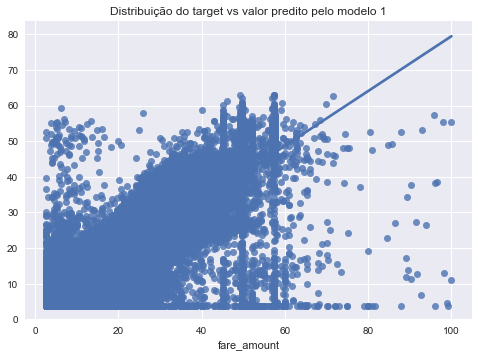

In [315]:
sns.regplot(x=Y_test, y=Y_pred).set_title("Distribuição do target vs valor predito pelo modelo 1");

In [316]:
# Construindo a equação da reta para o modelo 1

a = modelo1.coef_
b = modelo1.intercept_
print(f'O coeficiente angular é {a}')
print(f'Quando x = 0, a reta intercepta o eixo y em {b}')

O coeficiente angular é [2.29068699]
Quando x = 0, a reta intercepta o eixo y em 3.678765566469539


In [317]:
# Modelo 2 - 'abs_diff_longitude'

Y_pred = modelo2.predict(X_test[['abs_diff_longitude']])

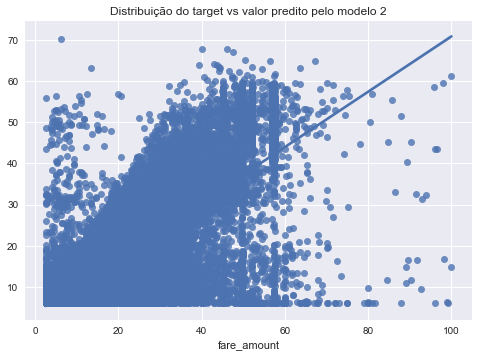

In [318]:
sns.regplot(x=Y_test, y=Y_pred).set_title("Distribuição do target vs valor predito pelo modelo 2");

In [319]:
# Construindo a equação da reta para o modelo 2

a = modelo2.coef_
b = modelo2.intercept_
print(f'O coeficiente angular é {a}')
print(f'Quando x = 0, a reta intercepta o eixo y em {b}')

O coeficiente angular é [223.97207148]
Quando x = 0, a reta intercepta o eixo y em 6.122002713633416


In [320]:
# Modelo 3 - 'abs_diff_latitude'

Y_pred = modelo3.predict(X_test[['abs_diff_latitude']])

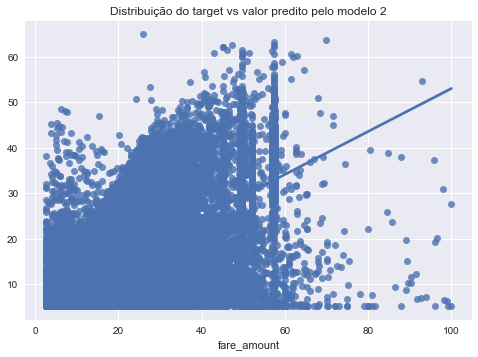

In [321]:
sns.regplot(x=Y_test, y=Y_pred).set_title("Distribuição do target vs valor predito pelo modelo 2");

In [322]:
# Construindo a equação da reta para o modelo 3

a = modelo3.coef_
b = modelo3.intercept_
print(f'O coeficiente angular é {a}')
print(f'Quando x = 0, a reta intercepta o eixo y em {b}')

O coeficiente angular é [283.51241848]
Quando x = 0, a reta intercepta o eixo y em 5.2158614822079015


## Métricas de avaliação

Neste exercício, serão utilizadas as seguintes métricas:
- MSE (Mean Squared Error)
- MAE (Mean Absolute Error)
- R²

In [323]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**`MSE`**

In [324]:
# Modelo 1

Y_pred = modelo1.predict(X_test[['trip_distance']])
mse = mean_squared_error(Y_test, Y_pred)
mse

18.040417958109902

In [325]:
# Modelo 2

Y_pred = modelo2.predict(X_test[['abs_diff_longitude']])
mse = mean_squared_error(Y_test, Y_pred)
mse

25.52796933561981

In [326]:
# Modelo 3

Y_pred = modelo3.predict(X_test[['abs_diff_latitude']])
mse = mean_squared_error(Y_test, Y_pred)
mse

41.403911592627026

**`MAE`**

In [327]:
# Modelo 1

Y_pred = modelo1.predict(X_test[['trip_distance']])
mae = mean_absolute_error(Y_test, Y_pred)
mae

2.30878441032883

In [328]:
# Modelo 2

Y_pred = modelo2.predict(X_test[['abs_diff_longitude']])
mae = mean_absolute_error(Y_test, Y_pred)
mae

3.2216211095095617

In [329]:
# Modelo 3

Y_pred = modelo3.predict(X_test[['abs_diff_latitude']])
mae = mean_absolute_error(Y_test, Y_pred)
mae

3.743234287027845

**`R²`**

In [330]:
# Modelo 1

Y_pred = modelo1.predict(X_test[['trip_distance']])
r2_score(Y_test, Y_pred)

0.7696717539154951

In [331]:
# Modelo 2

Y_pred = modelo2.predict(X_test[['abs_diff_longitude']])
r2_score(Y_test, Y_pred)

0.6740755997546544

In [332]:
# Modelo 3

Y_pred = modelo3.predict(X_test[['abs_diff_latitude']])
r2_score(Y_test, Y_pred)

0.4713819624184129

Verificando se os valores seriam melhores caso, ao invés de criar um modelo de regressão linear, fosse utilizada a mediana os valores pagos na corrida

In [333]:
X_test['median_fare_amount'] = Y_train.median()
mae = mean_absolute_error(Y_test, X_test['median_fare_amount'])
mae

5.124061100198704

In [334]:
r2_score(Y_test, X_test['median_fare_amount'])

-0.08387883592082068

Como observado, o modelo possui uma perfomance melhor que se feito pela mediana

## Regressão Linear Múltipla

In [366]:
# Escolhendo as features que mais se adequam

columns = ['pickup_longitude', 'dropoff_longitude', 'abs_diff_longitude', 'abs_diff_latitude', 'trip_distance']

In [367]:
modelo = LinearRegression()
modelo.fit(X_train[columns], Y_train)

LinearRegression()

In [368]:
Y_pred = modelo.predict(X_test[columns])

In [369]:
a=modelo.coef_
b=modelo.intercept_

In [370]:
a.tolist()

[11.914148369212253,
 1.2235136637529243,
 -59.33730535630904,
 -154.57801854040494,
 3.5704823592863097]

In [371]:
b

975.9167863366184

In [372]:
mae = mean_absolute_error(Y_test, Y_pred)
mae, r2_score(Y_test, Y_pred)

(2.22425895988916, 0.7863917026855107)

Aumentando o número de features, o MAE diminuiu e o R² aumentou

Visualizando o peso dos coeficientes:

In [343]:
weights = pd.DataFrame(list(zip(columns, modelo.coef_.tolist())),columns=['names', 'coefs'])
weights

,names,coefs
0,pickup_longitude,11.914148
1,dropoff_longitude,1.223514
2,abs_diff_longitude,-59.337305
3,abs_diff_latitude,-154.578019
4,trip_distance,3.570482


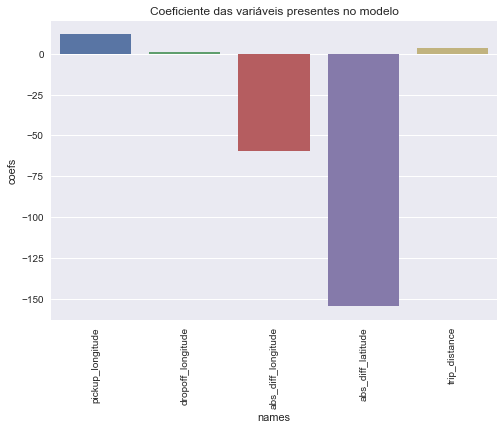

In [344]:
sns.barplot(weights.names, weights.coefs).set_title("Coeficiente das variáveis presentes no modelo");
plt.xticks(rotation=90);

É possível observar que as features mais relacionados ao target são das diferenças absolutas entre as latitudes e longitudes.

Mas será que faz sentido deixar essas features correlacionadas e que já estão presentes em outras features que criamos, como a `pickup_longitude`?

Podemos treinar mais um modelo de regressão linear múltipla, mas dessa vez removendo as features correlacionadas:

In [360]:
modelo.fit(X_train[['passenger_count', 'pickup_hour', 'pickup_day_of_week', 'pickup_day',
       'pickup_month', 'pickup_year', 'abs_diff_longitude', 'abs_diff_latitude', 'trip_distance']], Y_train)

LinearRegression()

In [361]:
Y_pred = modelo.predict(X_test[['passenger_count', 'pickup_hour', 'pickup_day_of_week', 'pickup_day',
       'pickup_month', 'pickup_year', 'abs_diff_longitude', 'abs_diff_latitude', 'trip_distance']])

In [364]:
mae = mean_absolute_error(Y_test, Y_pred)
mae, r2_score(Y_test, Y_pred)

(2.1106096338160527, 0.7961955715243919)

Apesar de uma diferença pequena, é notável um melhor resultado deste modelo.